# Tutorial 1: Decoding Neural Responses

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

---
# Tutorial Objectives

In this tutorial, we'll use deep learning to decode stimulus information from the responses of sensory neurons. Specifically, we'll look at the activity of ~20,000 neurons in the mouse primary visual cortex responding to oriented gratings recorded in [this study](https://www.biorxiv.org/content/10.1101/679324v2.abstract). Our task will be to decode the orientation of the presented stimulus from the responses of the whole population of neurons.

The goal will be learning how to:
* Build a deep feed-forward network using PyTorch
* Evaluate the network's outputs using PyTorch built-in loss functions
* Compute gradients of the loss with respect to each parameter of the network using automatic differentiation
* Implement gradient descent to optimize the network's parameters

In [6]:
# Imports
import os
import numpy as np

import torch
from torch import nn
from torch import optim

import matplotlib as mpl
from matplotlib import pyplot as plt

In [7]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Figure Settings (provided by NMA)

In [8]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

# Plotting Functions (provided by NMA)

In [9]:
def plot_data_matrix(X, ax, show=False):
  """Visualize data matrix of neural responses using a heatmap

  Args:
    X (torch.Tensor or np.ndarray): matrix of neural responses to visualize
        with a heatmap
    ax (matplotlib axes): where to plot
    show (boolean): enable plt.show()

  """

  cax = ax.imshow(X, cmap=mpl.cm.pink, vmin=np.percentile(X, 1),
                  vmax=np.percentile(X, 99))
  cbar = plt.colorbar(cax, ax=ax, label='normalized neural response')

  ax.set_aspect('auto')
  ax.set_xticks([])
  ax.set_yticks([])
  if show:
    plt.show()


def plot_train_loss(train_loss):
  plt.plot(train_loss)
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.xlabel('iterations of gradient descent')
  plt.ylabel('mean squared error')
  plt.show()

# Helper Functions (provided by NMA)

In [11]:
def load_data(data_name, bin_width=1):
  """Load mouse V1 data from Stringer et al. (2019)

  Data from study reported in this preprint:
  https://www.biorxiv.org/content/10.1101/679324v2.abstract

  These data comprise time-averaged responses of ~20,000 neurons
  to ~4,000 stimulus gratings of different orientations, recorded
  through Calcium imaging. The responses have been normalized by
  spontaneous levels of activity and then z-scored over stimuli, so
  expect negative numbers. They have also been binned and averaged
  to each degree of orientation.

  This function returns the relevant data (neural responses and
  stimulus orientations) in a torch.Tensor of data type torch.float32
  in order to match the default data type for nn.Parameters in
  Google Colab.

  This function will actually average responses to stimuli with orientations
  falling within bins specified by the bin_width argument. This helps
  produce individual neural "responses" with smoother and more
  interpretable tuning curves.

  Args:
    bin_width (float): size of stimulus bins over which to average neural
      responses

  Returns:
    resp (torch.Tensor): n_stimuli x n_neurons matrix of neural responses,
        each row contains the responses of each neuron to a given stimulus.
        As mentioned above, neural "response" is actually an average over
        responses to stimuli with similar angles falling within specified bins.
    stimuli: (torch.Tensor): n_stimuli x 1 column vector with orientation
        of each stimulus, in degrees. This is actually the mean orientation
        of all stimuli in each bin.

  """
  with np.load(data_name) as dobj:
    data = dict(**dobj)
  resp = data['resp']
  stimuli = data['stimuli']

  if bin_width > 1:
    # Bin neural responses and stimuli
    bins = np.digitize(stimuli, np.arange(0, 360 + bin_width, bin_width))
    stimuli_binned = np.array([stimuli[bins == i].mean() for i in np.unique(bins)])
    resp_binned = np.array([resp[bins == i, :].mean(0) for i in np.unique(bins)])
  else:
    resp_binned = resp
    stimuli_binned = stimuli

  # Return as torch.Tensor
  resp_tensor = torch.tensor(resp_binned, dtype=torch.float32)
  stimuli_tensor = torch.tensor(stimuli_binned, dtype=torch.float32).unsqueeze(1)  # add singleton dimension to make a column vector

  return resp_tensor, stimuli_tensor


def get_data(n_stim, train_data, train_labels):
  """ Return n_stim randomly drawn stimuli/resp pairs

  Args:
    n_stim (scalar): number of stimuli to draw
    resp (torch.Tensor):
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data, in radians

  Returns:
    (torch.Tensor, torch.Tensor): n_stim x n_neurons tensor of neural responses and n_stim x 1 of orientations respectively
  """
  n_stimuli = train_labels.shape[0]
  istim = np.random.choice(n_stimuli, n_stim)
  r = train_data[istim]  # neural responses to this stimulus
  ori = train_labels[istim]  # true stimulus orientation

  return r, ori

# Data retrieval and loading (provided by NMA)

In [12]:
import hashlib
import requests

fname = "W3D4_stringer_oribinned1.npz"
url = "https://osf.io/683xc/download"
expected_md5 = "436599dfd8ebe6019f066c38aed20580"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    elif hashlib.md5(r.content).hexdigest() != expected_md5:
      print("!!! Data download appears corrupted !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

# Load, split and visualize data

In the next cell, we have provided code to load the data and plot the matrix of neural responses.

Next to it, we plot the tuning curves of three randomly selected neurons. These tuning curves are the averaged response of each neuron to oriented stimuli within 1$^\circ$, and since there are 360$^\circ$ in total, we have 360 responses.

In the recording, there were actually thousands of stimuli shown, but in practice we often create these tuning curves because we want to visualize averaged responses with respect to the variable we varied in the experiment, in this case stimulus orientation.

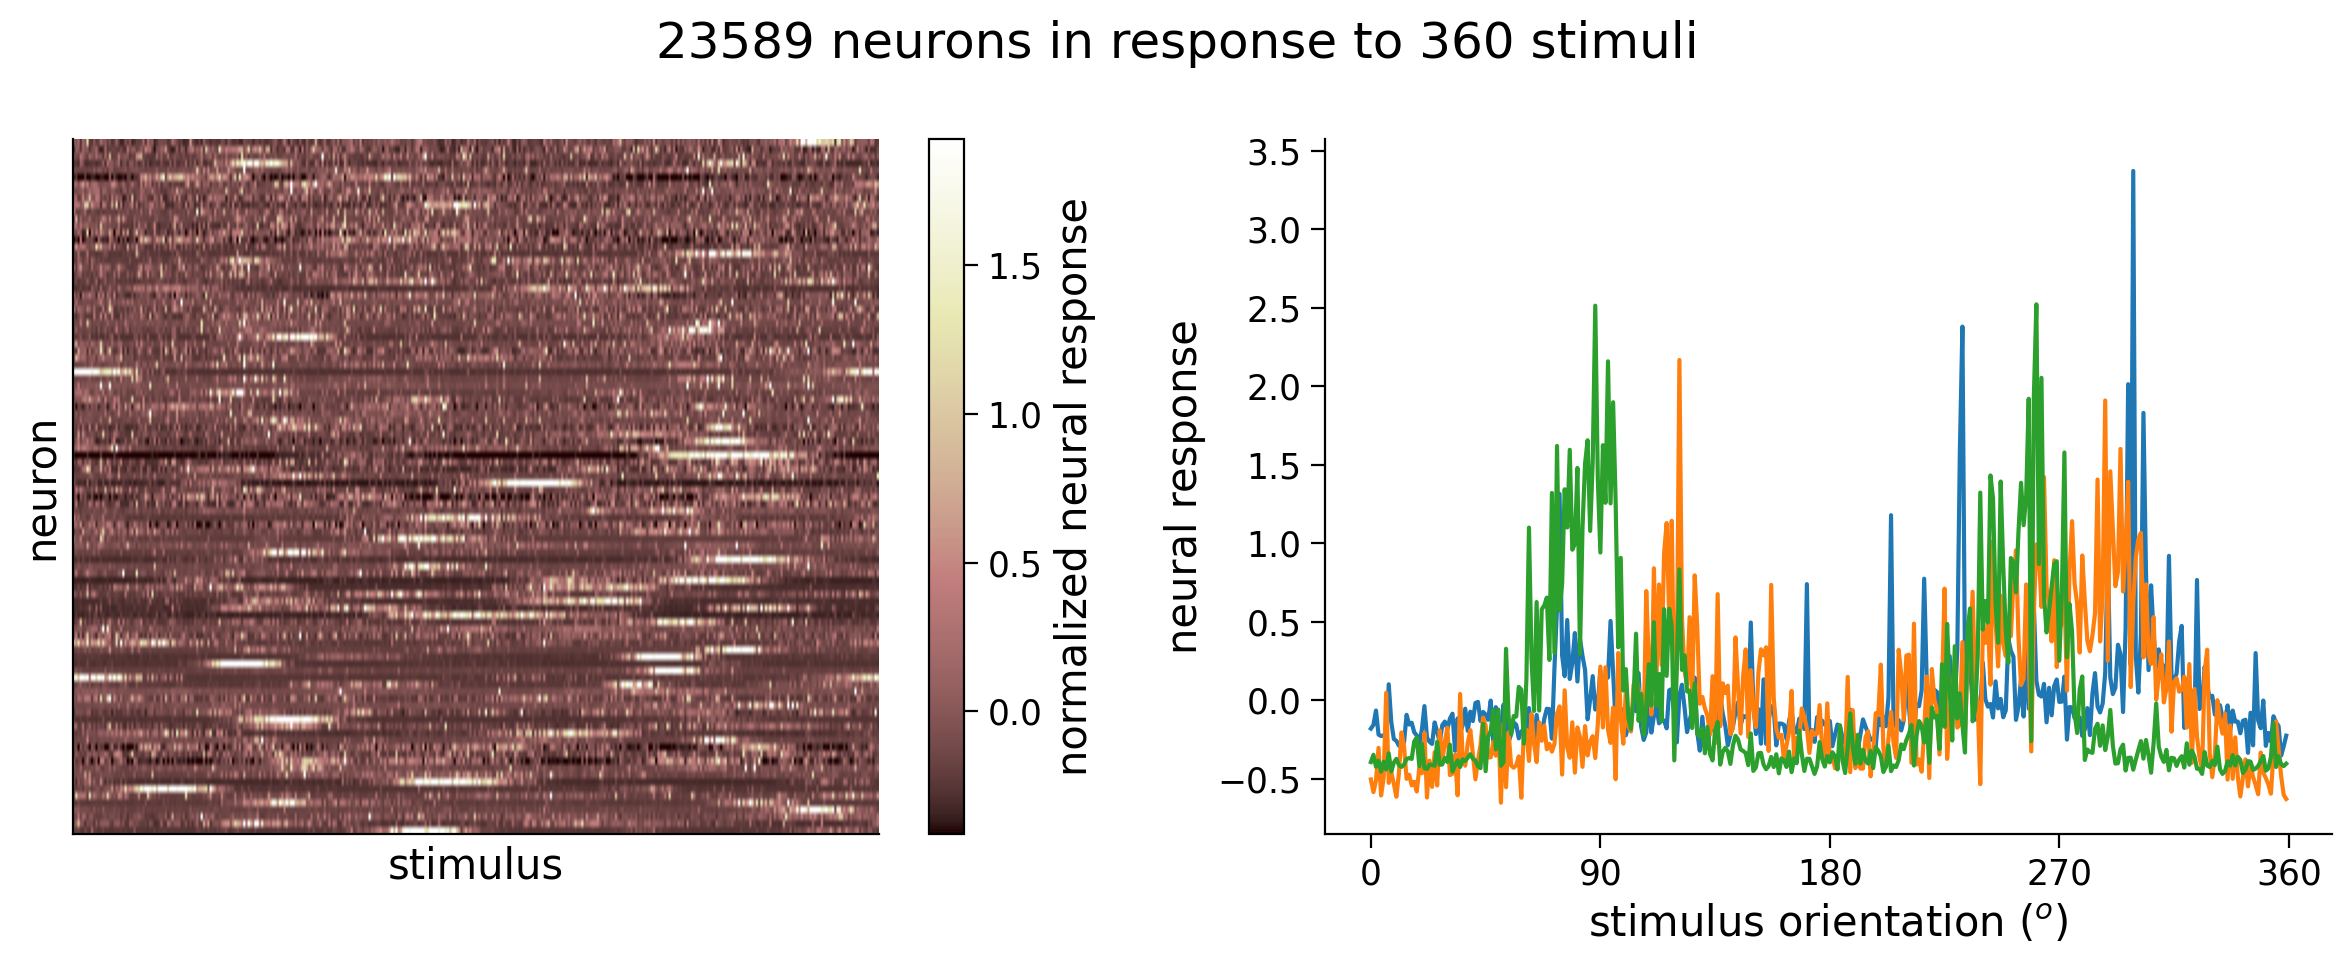

In [14]:
# Execute this cell to load and visualize data

# Load data
resp_all, stimuli_all = load_data(fname)  # argument to this function specifies bin width
n_stimuli, n_neurons = resp_all.shape

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 6, 5))

# Visualize data matrix
plot_data_matrix(resp_all[:, :100].T, ax1)  # plot responses of first 100 neurons
ax1.set_xlabel('stimulus')
ax1.set_ylabel('neuron')

# Plot tuning curves of three random neurons
ineurons = np.random.choice(n_neurons, 3, replace=False)  # pick three random neurons
ax2.plot(stimuli_all, resp_all[:, ineurons])
ax2.set_xlabel('stimulus orientation ($^o$)')
ax2.set_ylabel('neural response')
ax2.set_xticks(np.linspace(0, 360, 5))

fig.suptitle(f'{n_neurons} neurons in response to {n_stimuli} stimuli')
fig.tight_layout()
plt.show()

We will split our data into a training set and test set. In particular, we will have a training set of orientations (stimuli_train) and the corresponding responses (resp_train). Our testing set will have held-out orientations (stimuli_test) and the corresponding responses (resp_test).

In [15]:
# Execute this cell to split into training and test sets

# Set random seeds for reproducibility
np.random.seed(4)
torch.manual_seed(4)
# Section 2: Deep feed-forward networks in *pytorch*

# Split data into training set and testing set
n_train = int(0.6 * n_stimuli)  # use 60% of all data for training set
ishuffle = torch.randperm(n_stimuli)
itrain = ishuffle[:n_train]  # indices of data samples to include in training set
itest = ishuffle[n_train:]  # indices of data samples to include in testing set
stimuli_test = stimuli_all[itest]
resp_test = resp_all[itest]
stimuli_train = stimuli_all[itrain]
resp_train = resp_all[itrain]

# Section 2: Deep feed-forward networks in *pytorch*
We'll now build a simple deep neural network that takes as input a vector of neural responses and outputs a single number representing the decoded stimulus orientation.

Let $\mathbf{r}^{(n)} = \begin{bmatrix} r_1^{(n)} & r_2^{(n)} & \ldots & r_N^{(n)} \end{bmatrix}^\top$ denote the vector of neural responses (of neurons $1, \ldots, N$) to the $n$th stimulus. The network we will use is described by the following set of equations:

\begin{align}
\mathbf{h}^{(n)} &= \mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in}, && [\mathbf{W}^{in}: M \times N \, , \, \mathbf{b}^{in}: M \times 1] \, , \\
y^{(n)} &= \mathbf{W}^{out} \mathbf{h}^{(n)} + \mathbf{b}^{out},  && [\mathbf{W}^{out}: 1 \times M \, , \, \mathbf{b}^{in}: 1 \times 1] \, ,
\end{align}

where $y^{(n)}$ denotes the scalar output of the network: the decoded orientation of the $n$-th stimulus.

The next cell contains code for building the deep network we defined above and in the video using the nn.Module base class for deep neural network models 

In [17]:
class DeepNet(nn.Module):
  """Deep Network with one hidden layer

  Args:
    n_inputs (int): number of input units
    n_hidden (int): number of units in hidden layer

  Attributes:
    in_layer (nn.Linear): weights and biases of input layer
    out_layer (nn.Linear): weights and biases of output layer

  """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):
    """Decode stimulus orientation from neural responses

    Args:
      r (torch.Tensor): vector of neural responses to decode, must be of
        length n_inputs. Can also be a tensor of shape n_stimuli x n_inputs,
        containing n_stimuli vectors of neural responses

    Returns:
      torch.Tensor: network outputs for each input provided in r. If
        r is a vector, then y is a 1D tensor of length 1. If r is a 2D
        tensor then y is a 2D tensor of shape n_stimuli x 1.

    """
    h = self.in_layer(r)  # hidden representation
    y = self.out_layer(h)
    return y

#### Coding Exercise 2.2: Nonlinear Activations

Create a new class `DeepNetReLU` by modifying our above deep network model to add a **non-linear activation** function $\phi$:
\begin{equation}
\mathbf{h}^{(n)} = \phi(\mathbf{W}^{in} \mathbf{r}^{(n)} + \mathbf{b}^{in})
\end{equation}

We'll use the linear rectification function:

\begin{equation}
\phi(x) =
\begin{cases}
x & \text{if } x > 0 \\
0 & \text{else}
\end{cases}
\end{equation}

which can be implemented in PyTorch using `torch.relu()`.

Initialize this network with 10 hidden units and run on an example stimulus.

<br>

We then initialize and run this network. We use it to decode stimulus orientation (true stimulus given by `ori`) from a vector of neural responses `r` to the very first stimulus. Note that when the initialized network class is called as a function on an input (e.g., `net(r)`), its `.forward()` method is called. This is a special property of the `nn.Module` class.

Note that the decoded orientations at this point will be nonsense, since the network has been initialized with random weights.

In [18]:
class DeepNetReLU(nn.Module):
  """ network with a single hidden layer h with a RELU """

  def __init__(self, n_inputs, n_hidden):
    super().__init__()  # needed to invoke the properties of the parent class nn.Module
    self.in_layer = nn.Linear(n_inputs, n_hidden) # neural activity --> hidden units
    self.out_layer = nn.Linear(n_hidden, 1) # hidden units --> output

  def forward(self, r):

    ############################################################################
    ## TO DO for students: write code for computing network output using a
    ## rectified linear activation function for the hidden units
    # Fill out function and remove
    # raise NotImplementedError("Student exercise: complete DeepNetReLU forward")
    ############################################################################

    h =  torch.relu(self.in_layer(r)) # h is size (n_inputs, n_hidden)
    y = self.out_layer(h) # y is size (n_inputs, 1)


    return y


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=200 hidden units
net = DeepNetReLU(n_neurons, 200)

# Get neural responses (r) to and orientation (ori) to one stimulus in dataset
r, ori = get_data(1, resp_train, stimuli_train)  # using helper function get_data

# Decode orientation from these neural responses using initialized network
out = net(r)  # compute output from network, equivalent to net.forward(r)

print(f'decoded orientation: {out.item():.2f} degrees')
print(f'true orientation: {ori.item():.2f} degrees')

decoded orientation: 0.17 degrees
true orientation: 139.00 degrees


**Computing MSE**


Evaluate the mean squared error for a deep network with $M=10$ rectified linear units, on the decoded orientations from neural responses to 20 random stimuli.

In [19]:
# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize a deep network with M=10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Get neural responses to first 20 stimuli in the data set
r, ori = get_data(20, resp_train, stimuli_train)

# Decode orientation from these neural responses
out = net(r)

# Initialize PyTorch mean squared error loss function (Hint: look at nn.MSELoss)
loss_fn = nn.MSELoss()

# Evaluate mean squared error
loss = loss_fn(out, ori)

print(f'mean squared error: {loss:.2f}')

mean squared error: 42949.14


In [20]:
# Execute this cell to view gradient descent gif

from IPython.display import Image
Image(url='https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/grad_descent.gif?raw=true')

#### Coding Exercise: Gradient descent in PyTorch

Complete the function `train()` that uses the gradient descent algorithm to optimize the weights of a given network. This function takes as input arguments
* `net`: the PyTorch network whose weights to optimize
* `loss_fn`: the PyTorch loss function to use to evaluate the loss
* `train_data`: the training data to evaluate the loss on (i.e., neural responses to decode)
* `train_labels`: the target outputs for each data point in `train_data` (i.e., true stimulus orientations)

We will then train a neural network on our data and plot the loss (mean squared error) over time. When we run this function, behind the scenes PyTorch is actually changing the parameters inside this network to make the network better at decoding, so its weights will now be different than they were at initialization.

iteration 10/50 | loss: 12219.761
iteration 20/50 | loss: 1672.732
iteration 30/50 | loss: 548.097
iteration 40/50 | loss: 235.619
iteration 50/50 | loss: 144.001


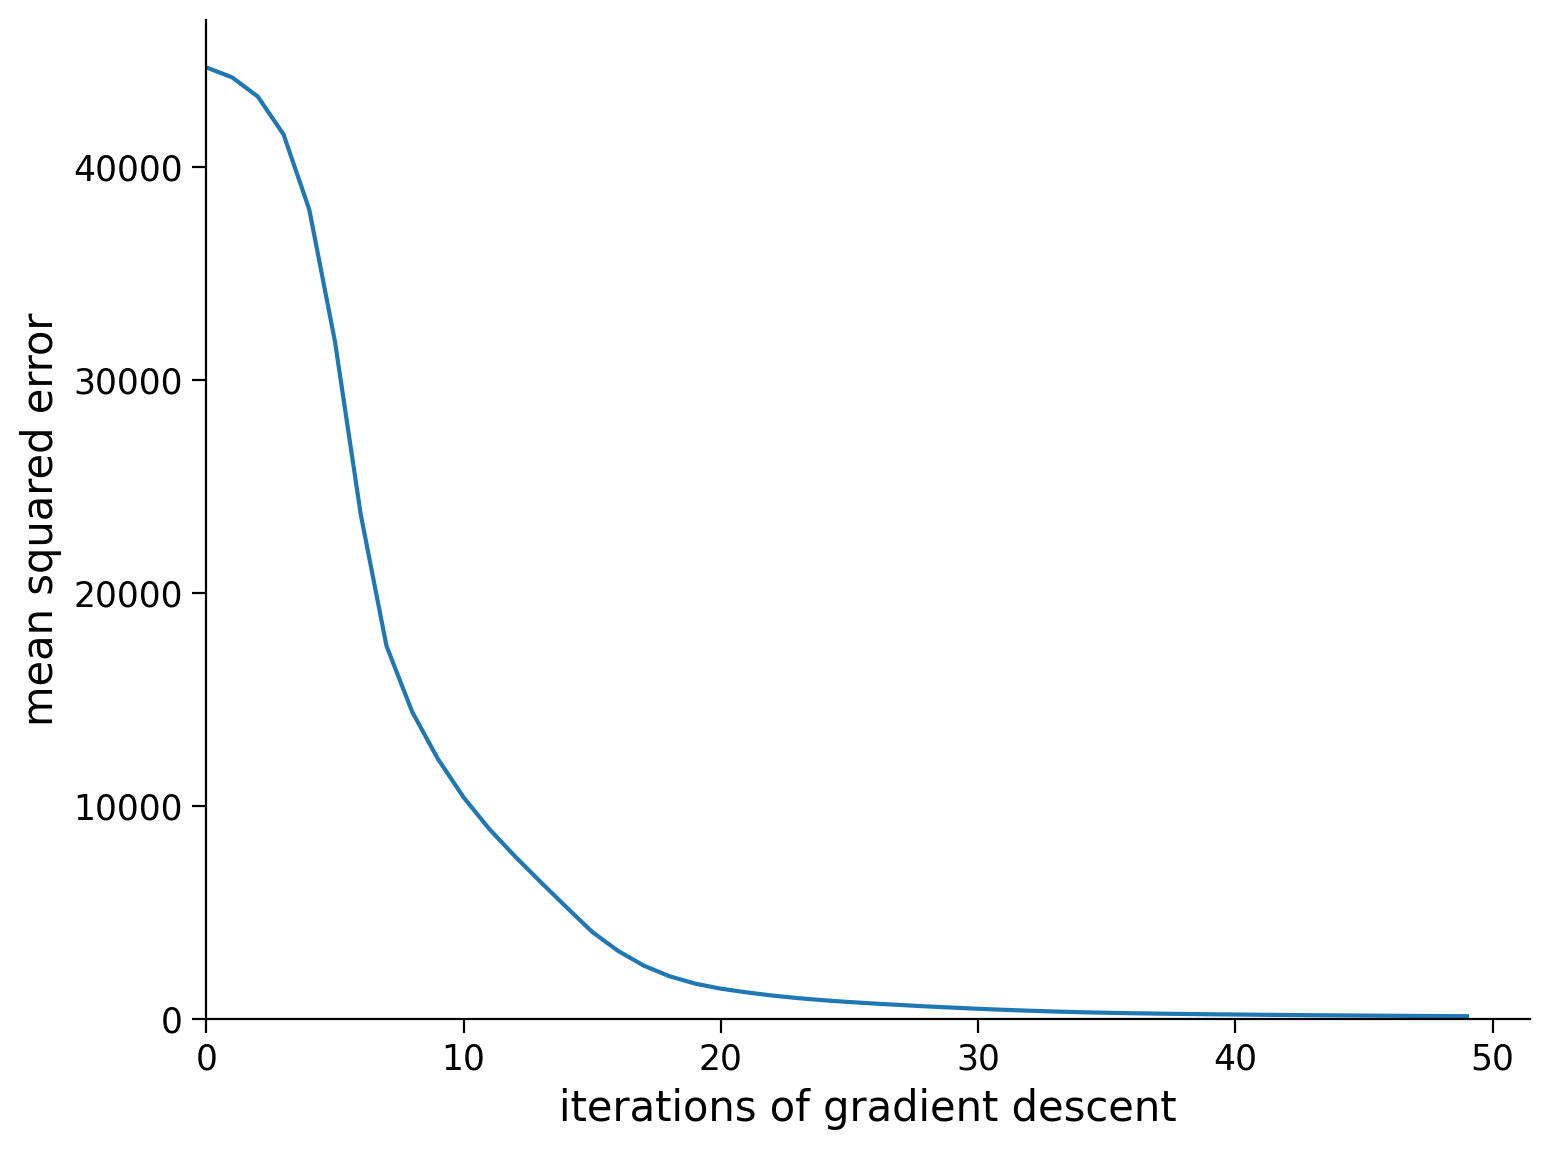

In [21]:
def train(net, loss_fn, train_data, train_labels,
          n_epochs=50, learning_rate=1e-4):
  """Run gradient descent to optimize parameters of a given network

  Args:
    net (nn.Module): PyTorch network whose parameters to optimize
    loss_fn: built-in PyTorch loss function to minimize
    train_data (torch.Tensor): n_train x n_neurons tensor with neural
      responses to train on
    train_labels (torch.Tensor): n_train x 1 tensor with orientations of the
      stimuli corresponding to each row of train_data
    n_epochs (int, optional): number of epochs of gradient descent to run
    learning_rate (float, optional): learning rate to use for gradient descent

  Returns:
    (list): training loss over iterations

  """

  # Initialize PyTorch SGD optimizer
  optimizer = optim.SGD(net.parameters(), lr=learning_rate)

  # Placeholder to save the loss at each iteration
  train_loss = []

  # Loop over epochs
  for i in range(n_epochs):

    ######################################################################
    ## TO DO for students: fill in missing code for GD iteration
    # raise NotImplementedError("Student exercise: write code for GD iterations")
    ######################################################################

    # compute network output from inputs in train_data
    out = net(train_data)  # compute network output from inputs in train_data

    # evaluate loss function
    loss = loss_fn(out, train_labels)

    # Clear previous gradients
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update weights
    optimizer.step()

    # Store current value of loss
    train_loss.append(loss.item())  # .item() needed to transform the tensor output of loss_fn to a scalar

    # Track progress
    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss


# Set random seeds for reproducibility
np.random.seed(1)
torch.manual_seed(1)

# Initialize network with 10 hidden units
net = DeepNetReLU(n_neurons, 10)

# Initialize built-in PyTorch MSE loss function
loss_fn = nn.MSELoss()

# Run gradient descent on data
train_loss = train(net, loss_fn, resp_train, stimuli_train)

# Plot the training loss over iterations of GD
plot_train_loss(train_loss)